## Import and load files

In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [2]:
# load paths 
TRAIN_IMG_PATH = "/Users/anthony/Documents/Comp551_KaggleData/train_images.npy"
TRAIN_LAB_PATH = "/Users/anthony/Documents/Comp551_KaggleData/train_labels.csv"

# Load images
images = np.load(TRAIN_IMG_PATH, encoding='bytes')
print(images.shape)

# Load labels
label_df = pd.read_csv(TRAIN_LAB_PATH)
print(len(label_df))
label_df[0:3]

(10000, 2)
10000


,Id,Category
0,0,shovel
1,1,rifle
2,2,scorpion


### Test Theo's image extraction functions
(as of November 9, 1:21pm)

In [3]:
## Theo's methods for contour finding ##
from skimage import measure
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


def getLongestContour(img):
    img_contours = measure.find_contours(img, 0.99, 'high')
    img_contours.sort(key=lambda x: len(x), reverse=True)
    return img_contours[0]

# need to wrap with try / except, for when contour is invalid 
def tryPolygonArea(contour):
    try:
        return Polygon(contour).area
    except:
        return 0

def getLargestContour(img):
    img_contours = measure.find_contours(img, 0.99, 'high')
    img_contours.sort(key=tryPolygonArea, reverse=True)
    return img_contours[0]
    

def overlayContour(img, contour):
    plt.imshow(img, cmap='gray_r')
    # Plot the longest contour
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.show()

In [4]:
### Theo's method for image pre-processing ###
from scipy.ndimage import zoom

## Dependencies of method ##

# Get the bounding box of the contour
def boundingBoxOfContour(contour):
    minX = float("inf")
    minY = float("inf")
    maxX = -1
    maxY = -1
    for x,y in contour:
        if minX > x:
            minX = x
        if minY > y:
            minY = y
        if maxX < x:
            maxX = x
        if maxY < y:
            maxY = y
    return minX, minY, maxX,maxY

# Removes noise based off of the bounding box of the longest contour. Buffer is how much additional 
# space we want to provide beyond the bounding box.
# If buffer < 1, it will add buffer equal to the (largest side of bounding box * buffer)
def removeNoiseViaBoundingBox(oldImg, buffer = 0, contour_type='longest'):
    if contour_type == 'longest':
        contour = getLongestContour(oldImg)
    elif contour_type == 'largest':
        contour = getLargestContour(oldImg)
    else:
        print("Invalid contour_type:", contour_type, ". Allowed values: longest, largest")
        raise
    minX, minY, maxX, maxY = boundingBoxOfContour(contour)
    
    if (buffer < 1):
        maxLength = max(maxX - minX, maxY - minY)
        buffer = buffer * maxLength
    # overlayContour(oldImg, np.array([[minX, minY], [minX, maxY], [maxX, maxY], [minX, maxY], [minX, minY]]))
    
    newImg = [[0 for j in range(len(oldImg[i]))] for i in range(len(oldImg))]
        
    #iterate through old image
    for x in range(len(oldImg)):
        for y in range(len(oldImg[x])):
            if x >= (minX - buffer) and x <= (maxX + buffer) and y >= (minY - buffer) and y <= (maxY + buffer):
                newImg[x][y] = oldImg[x][y]
    return newImg

#Finds the first non-zero coordinate, and the last non-zero coordinate.
def boundingBox(img):
    minX = -1
    minY = -1
    maxX = -1
    maxY = -1
    for i, row in enumerate(img):
        nonZeroIndexes = np.nonzero(row)[0]
        if len(nonZeroIndexes) != 0:
            if minX == -1:
                minX = i
            if minY == -1 or minY > np.min(nonZeroIndexes):
                minY = np.min(nonZeroIndexes)
            if maxX < i:
                maxX = i
            if maxY < np.max(nonZeroIndexes):
                maxY = np.max(nonZeroIndexes)
    return (minX, minY), (maxX,maxY)

# Centers the image
def center(img):
    minCoord, maxCoord = boundingBox(img)
    xLength = maxCoord[0] - minCoord[0]
    yLength = maxCoord[1] - minCoord[1]
    newImg = [[0 for j in range(len(img[i]))] for i in range(len(img))]
    
    startX = int((len(img) - xLength) / 2)
    startY = int((len(img[0]) - yLength) / 2)
    for i,x in enumerate(range(startX, startX + xLength + 1)):
        for j,y in enumerate(range(startY, startY + yLength + 1)):
            newImg[x][y] = img[minCoord[0]+i][minCoord[1]+j]
    return newImg

# Crop out all of the white space. If you want square dimensions, then it will pad white space.
def cropWhite(img, isSquare = False):
    minCoord, maxCoord = boundingBox(img)
    xLength = maxCoord[0] - minCoord[0]
    yLength = maxCoord[1] - minCoord[1]
    if isSquare:
        xLength = max(xLength, yLength)
        yLength = max(xLength, yLength)
    
    newImg = [[0 for j in range(yLength + 1)] for i in range(xLength + 1)]
    for i in range(xLength + 1):
        for j in range(yLength + 1):
            # Check for case where we are out of bounds for cropped white + square
            if (minCoord[0] + i) >= len(img) or (minCoord[1] + j) >= len(img[i]):
                newImg[i][j] = 0
            else:
                newImg[i][j] = img[minCoord[0] + i][minCoord[1] + j]
    return newImg

# rescale image to square of height, width = dimension    
def rescale(img, dimension):
    cropped = cropWhite(img)
    height = len(cropped)
    width = len(cropped[0])
    zoomFactor = dimension / max(height, width)
    return zoom(img, zoomFactor, order=0)

## Actual preprocessing method ##
def preprocessImg(img, noiseRemoveType='bounding_box', contour_type='largest', rescaleDimension = 40):
    if noiseRemoveType == 'bounding_box':
        filteredImg = removeNoiseViaBoundingBox(img, .2, contour_type)
    elif noiseRemoveType == 'longest_contour':
        filteredImg = removeNoiseViaContour(img, contour_type)
    else:
        print("Invalid noiseRemoveType:", noiseRemoveType, ". Allowed values: bounding_box, longest_contour")
        raise 
    croppedImg = cropWhite(filteredImg, True)
    centered_img = center(croppedImg)
    rescaled_img = rescale(centered_img, rescaleDimension)
    return rescaled_img

    Id Category
10  10   peanut


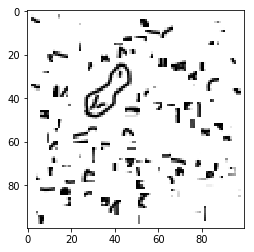

In [5]:
testIdx = 10

tmpTestImg = images[testIdx][1].reshape((100,100)).astype(np.uint8)

print(label_df.iloc[[testIdx]])

plt.imshow(tmpTestImg, cmap='gray_r')
plt.show()

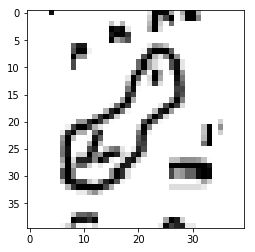

In [6]:
tmpProcessedImg = preprocessImg(tmpTestImg)

plt.imshow(tmpProcessedImg, cmap='gray_r')
plt.show()

## Pre-process 
### Generate feature dictionaries

In [7]:
len(images)

10000

#### Extract the sub-image (for a subset) of the image set

In [8]:
# how many to extract
N_SUBSET = 2000
# dimension (in pixels) of each (squared) image
IMG_DIM = 20

# Pre-allocate array to store sub images
subImagesMat = np.empty((N_SUBSET,IMG_DIM,IMG_DIM))

#Use a subset of the images
for imgIdx in range(N_SUBSET):
    # Get the image
    curImg = images[imgIdx][1].reshape((100,100)).astype(np.uint8)
    # Pre-process it to get the sub image
    subImg = preprocessImg(curImg, rescaleDimension=IMG_DIM)
    # Save to sub-array
    subImagesMat[imgIdx,:,:] = subImg

print(np.shape(subImagesMat))

(2000, 20, 20)


   Id Category
3   3    apple


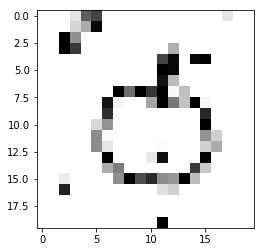

In [9]:
## Visualize a test image
tmpTestImg = subImagesMat[3]

print(label_df.iloc[[3]])

plt.imshow(tmpTestImg, cmap='gray_r')
plt.show()

### Extract descriptors features from the sub-image
**Horizontal and vertical sums of pixel values**

In [11]:
# pre-allocate array
hori_pixSum = np.empty((N_SUBSET, IMG_DIM))
vert_pixSum = np.empty((N_SUBSET, IMG_DIM))

# Compute sums 
for i, curImg in enumerate(subImagesMat):
    # Compute horizontal sum
    hori_pixSum[i,:] = np.sum(curImg, axis=0)
    # Compute vertical sum
    vert_pixSum[i,:] = np.sum(curImg, axis=1)

print(np.shape(hori_pixSum))
print(np.shape(vert_pixSum))

(2000, 20)
(2000, 20)


** Descriptor terms for the image histogram **

Taking the histogram of hessian to capture the change in image

In [12]:
from skimage import filters

summaryPixStatsLists = []

# Compute sums 
for i, curImg in enumerate(subImagesMat):
    # Filter the image to get a hessian
    imgHessian = filters.hessian(curImg)
    
    # Take some summary statistics
    curMean = np.mean(imgHessian.flatten())
    curStd = np.std(imgHessian.flatten())
    firstQuartile = np.percentile(imgHessian.flatten(), 25)
    thirdQuartile = np.percentile(imgHessian.flatten(), 75)
    
    # Save
    summaryPixStatsLists.append( [curMean, curStd, firstQuartile, thirdQuartile] )

# Convert the 2d array to a numpy array
summaryPixStats = np.array(summaryPixStatsLists)
np.shape(summaryPixStats)

(2000, 4)

** Some feature extraction from skimage **

Using the shape index, which defines local shapes:
http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.shape_index

In [34]:
from skimage import feature

NAIVE_BINS = 10

shapeIndHists = np.empty((N_SUBSET, NAIVE_BINS))


# Compute sums 
for i, curImg in enumerate(subImagesMat):
    # Get the shape index of the image
    imgShapeIndex = feature.shape_index(curImg).flatten()
    
    imgShapeIndex = imgShapeIndex[~np.isnan(imgShapeIndex)]
    
    # Get a summary histogram of the shape index into (naive) evenly divided bins
    shapeIdxHist, __ = np.histogram(imgShapeIndex, bins=NAIVE_BINS)
    
    # Save 
    shapeIndHists[i,:] = shapeIdxHist

np.shape(shapeIndHists)

/Users/anthony/anaconda3/envs/ImgCV/lib/python3.6/site-packages/skimage/feature/corner.py:373: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))


(2000, 10)

** Just flatten the image fam **

In [46]:
flattenedImageVec = np.empty((N_SUBSET, (IMG_DIM*IMG_DIM)))

# Compute sums 
for i, curImg in enumerate(subImagesMat):
    flattenedImageVec[i] = curImg.flatten()

np.shape(flattenedImageVec)

(2000, 400)

** TODO: get more features **

#### Concatenate features and get labels

In [61]:
# Get feature 
X_preScale = np.hstack((hori_pixSum, vert_pixSum, summaryPixStats, shapeIndHists, flattenedImageVec))

# Scale
from sklearn.preprocessing import normalize

X = normalize(X_preScale)

np.shape(X)

(2000, 454)

In [62]:
from sklearn.preprocessing import LabelEncoder

# Get text labels
string_labels = label_df.head(n=N_SUBSET)['Category'].values

# Encode string to integer
le = LabelEncoder()
le.fit(string_labels)
y = le.transform(string_labels)

print(np.shape(y))

(2000,)


# Classification
### RandomForest Classifier

In [63]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [64]:
from sklearn.ensemble import RandomForestClassifier

K_FOLD = 5

# Performance
F1_Performance_arr = np.empty(K_FOLD)
accuracy_arr = np.empty(K_FOLD)


# K-fold split
kf = KFold(n_splits=K_FOLD)
kf.get_n_splits(X)

# Start K-fold cross validation
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print("K-fold iteration: %d" % (i+1))
    # Split training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Initialize classifier
    randForest = RandomForestClassifier(n_estimators=300, max_depth=3, random_state=0)
    # Fit classifier
    randForest.fit(X_train, y_train)
    
    # Predict test set
    y_pred = randForest.predict(X_test)
    
    # Get performance
    F1_Performance_arr[i] = f1_score(y_test, y_pred, average='micro')
    accuracy_arr[i] = accuracy_score(y_test, y_pred)
        

K-fold iteration: 1
K-fold iteration: 2
K-fold iteration: 3
K-fold iteration: 4
K-fold iteration: 5


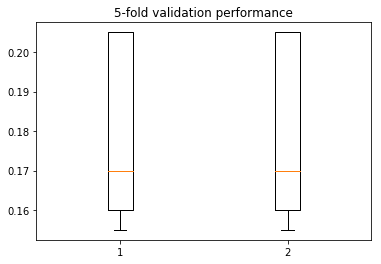

In [65]:
# Plot performance
plt.boxplot([accuracy_arr, F1_Performance_arr])
plt.title("%d-fold validation performance" % K_FOLD)
#plt.xticks([1,2], ['Accuracy', 'F1'])
plt.show()


### SVM

In [66]:
from sklearn.svm import SVC

K_FOLD = 5

# Performance
svm_F1_Performance_arr = np.empty(K_FOLD)
svm_accuracy_arr = np.empty(K_FOLD)


# K-fold split
kf = KFold(n_splits=K_FOLD)
kf.get_n_splits(X)

# Start K-fold cross validation
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print("K-fold iteration: %d" % (i+1))
    # Split training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Initialize classifier
    clf = SVC(kernel='rbf', gamma='auto', random_state=0)
    # Fit classifier
    clf.fit(X_train, y_train)
    
    # Predict test set
    y_pred = clf.predict(X_test)
    
    # Get performance
    svm_F1_Performance_arr[i] = f1_score(y_test, y_pred, average='micro')
    svm_accuracy_arr[i] = accuracy_score(y_test, y_pred)

K-fold iteration: 1
K-fold iteration: 2
K-fold iteration: 3
K-fold iteration: 4
K-fold iteration: 5


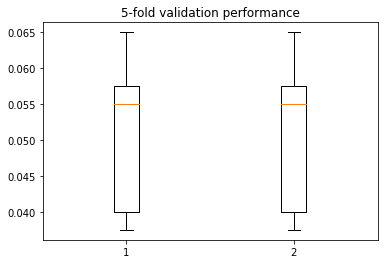

In [67]:
## Plot ##
# Plot performance
plt.boxplot([svm_accuracy_arr, svm_F1_Performance_arr])
plt.title("%d-fold validation performance" % K_FOLD)
plt.show()
